In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

#import warnings
#warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'sans-serif'

# Plot colors
def get_region(id):
    id = int(id)
    if id == 186:
        return "green"
    elif id < 75:
        return "gray"
    elif id >= 75 and id < 150:
        return "red"
    elif id >= 150 and id < 250 and id != 186:
        return "blue"
    elif id >= 250:
        return "purple"
    
def plot_feature_importances(result, x, title, append,cutoff=0,std_flag=True):
    '''
    plot the feature importances from results of permutation
    std_flag: if True, apply the mean>2*std filter
    '''
    # Read the feature importance into a data frame and get the region from each feature
    df = pd.DataFrame({'feature_name': x.columns, 'feature_importance': result.importances_mean,'feature_std': result.importances_std})
    df2 = df[df["feature_importance"] > cutoff].dropna().sort_values(by=['feature_importance'], ascending=False)
    if std_flag:
        df2 = df2[df2["feature_importance"] > 2 * df2["feature_std"]]
        
    colors = [get_region(i.split("_")[0]) for i in df2["feature_name"].values]
    
    # Plotting time
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(
        data= df2, 
        x='feature_importance', 
        y='feature_name', 
        palette=colors,
    )

#    # Annotate all bars in the barplot
#    for container in ax.containers:
#        ax.bar_label(container, fmt="%.4f",fontsize=12)
        
    # Get vertical positions of bars from the center of each patch
    y_positions = [patch.get_y() + patch.get_height() / 2 for patch in ax.patches]
    x_positions = [patch.get_width() for patch in ax.patches]

    # Add error bars for each feature and text
    for x, y, imp, std in zip(x_positions,y_positions, df2['feature_importance'], df2['feature_std']):
        ax.errorbar(
            x=imp,
            y=y,
            xerr=std,
            fmt='none',
            ecolor='black',
            capsize=6,
            capthick=2,
            linewidth=2
        )
        ax.text(
            x + 0.0012,         # small horizontal offset to the right
            y,
            f"{imp:.4f}",   # label text formatted to 4 decimals
            va='center',
            ha='left',
            fontsize=12
        )
    
    # Increase font sizes
    plt.xticks(fontsize=14)  # Increase tick font size
    plt.yticks(fontsize=14)
    plt.xlabel("Feature Importance", fontsize=16, labelpad=10)  # Increase axis label size
    plt.ylabel("Feature Name", fontsize=16, labelpad=10)
    plt.title(title, fontsize=17, pad=15)  # Increase title size        

    # Compute dynamic x-axis limit
    max_val = (df2["feature_importance"] + df2["feature_std"]).max()
    ax.set_xlim([0, max_val * 1.1])  # add 15% padding

    plt.tight_layout()
    # Save the feature importance plot
    plt.savefig(f"permutation_feature_importances_{append}.jpg")
    
    return df2


def compute_and_plot_feature_importances(
    model, x, y, 
    title='Permutation Feature Importance', 
    append='all', 
    n_repeats=100, 
    random_state=0, 
    n_jobs=40,
    cutoff=0.0
):
    # Permutation feature importances
    result = permutation_importance(model, x, y, n_repeats=n_repeats, random_state=random_state,n_jobs=n_jobs)
    
    # Read the feature importance into a data frame and get the region from each feature
    df = pd.DataFrame({'feature_name': x.columns, 'feature_importance': result.importances_mean})
    df2 = df[df["feature_importance"] > cutoff].dropna().sort_values(by=['feature_importance'], ascending=False)
    colors = [get_region(i.split("_")[0]) for i in df2["feature_name"].values]
    
    # Plotting time
    plt.figure(figsize=(8, 8))
    ax = sns.barplot(data= df2, x='feature_importance', y='feature_name', palette=colors)
#    c = 0
    
#    # Get rid of things that are close to zero - keep in mind that this does not match what the mathematica plot does
#    # Need to update such that all avg values (minus std) greater than 0 are kept
#    for i in ax.containers:
#        if i.datavalues[0] < 0.0002:
#            i.datavalues[0] = np.round(i.datavalues[0],4)
#            ax.bar_label(i, color=colors[c])
#        c = c + 1
        
    print(f"containers length: {len(ax.containers)}")
    # Annotate all bars in the barplot
    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f")
        
    plt.title(title)
    
    # Save the feature importance plot
    plt.savefig(f"permutation_feature_importances_{append}.jpg")
    plt.show()
    
    # Return the feature importance values for the mathematica plot
    return df2, result

# Function to plot feature importances from RandomForest model
def plot_feature_importances_rf(model, x,cutoff=0.0, title='RF Feature Importance', append='all'):

    # Get feature importances from RandomForest model
    feature_importances = model.feature_importances_

    # Create a DataFrame
    df = pd.DataFrame({'feature_name': x.columns, 'feature_importance': feature_importances})

    # Filter out zero-importance features and sort in descending order
    df_filtered = df.query(f"feature_importance > {cutoff}").dropna().sort_values(by='feature_importance', ascending=False)

    # Assign colors based on feature names
    colors = [get_region(i.split("_")[0]) for i in df_filtered["feature_name"].values]


    # Plot feature importances
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(data=df_filtered, x='feature_importance', y='feature_name', palette=colors)
    # Increase font sizes
    plt.xticks(fontsize=14)  # Increase tick font size
    plt.yticks(fontsize=14)
    plt.xlabel("Feature Importance", fontsize=16, labelpad=10)  # Increase axis label size
    plt.ylabel("Feature Name", fontsize=16, labelpad=10)
    plt.title(title, fontsize=18, pad=15)  # Increase title size
    print(f"containers length: {len(ax.containers)}")
# Annotate all bars in the barplot
    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f",fontsize=12)
        
    plt.title(title)

    # Save the feature importance plot
    plt.savefig(f"RF_model_feature_importances_{append}.jpg")
    plt.show()

    return df_filtered

In [2]:
# Test dataset
df_test = pd.read_csv('../07_preprocess/model/X_test_dt10_4.csv')
X_test = df_test.iloc[:,:-2]
Y_test = df_test.iloc[:,-2]

# Train dataset
df_train = pd.read_csv('../07_preprocess/model/X_train_dt10_4.csv')
X_train = df_train.iloc[:,:-2]
Y_train = df_train.iloc[:,-2]


# Optimized Parameters
nestimators = 200
maxdepth = 3
leaf = 1641

# Pipeline with fixed random seed
rf_pipeline = Pipeline(steps = [
    ("standardize", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=9, 
                                  max_depth=maxdepth,  
                                  n_estimators=nestimators, 
                                  min_samples_leaf=leaf,
                                  n_jobs=60,
                                 ))
])


In [2]:
# Fit to the train data
rf_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=1641,
                                        n_estimators=200, n_jobs=60,
                                        random_state=9))])

In [3]:
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)


train_accuracy = accuracy_score(Y_train,y_train_pred)
test_accuracy = accuracy_score(Y_test,y_test_pred)
print(f"Train accuracy: {train_accuracy:.4f}\nTest accuracy: {test_accuracy:.4f}")

Train accuracy: 1.0000
Test accuracy: 0.8847


In [5]:
#joblib.dump(rf_pipeline,'model/final_pipeline_0225.pkl')

['model/final_pipeline_0225.pkl']

# get feature importances

/tmp/ipykernel_80386/3466091685.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data= df2, x='feature_importance', y='feature_name', palette=colors)


containers length: 54


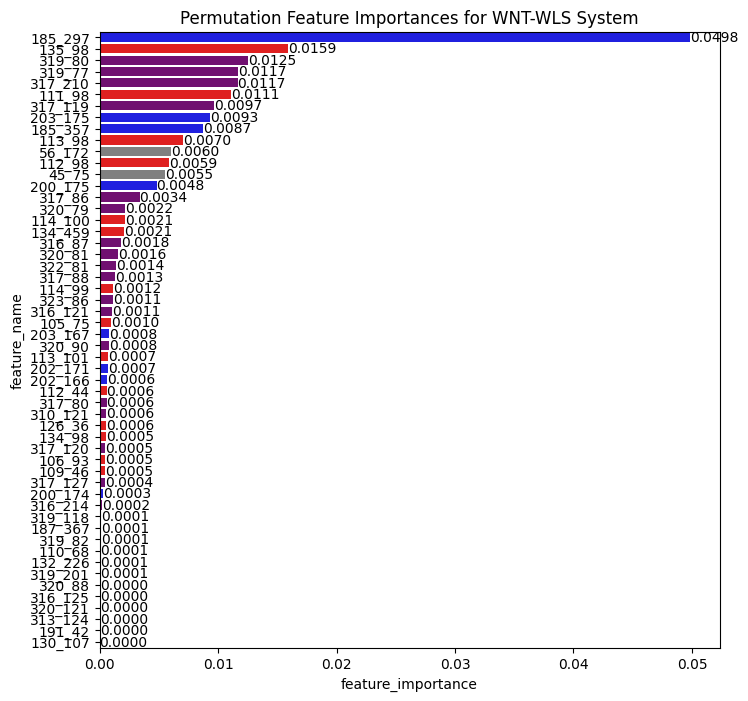

In [6]:
# Feature importances on the test data
df2, r = compute_and_plot_feature_importances(
    rf_pipeline, X_test, Y_test, 
    'Permutation Feature Importances for WNT-WLS System', "all",
    100,
    0,
    n_jobs=66
)


In [3]:
#joblib.dump(r,'output/permutation_result_0225.pkl')
r=joblib.load('output/permutation_result_0225.pkl')

In [9]:
# Print out the important features for mathematica plot
x = pd.DataFrame(np.transpose(r.importances), columns=X_test.columns)
x.to_csv("output/permutation_feature_importances_0225.csv",index=False)

/tmp/ipykernel_14358/2255854722.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


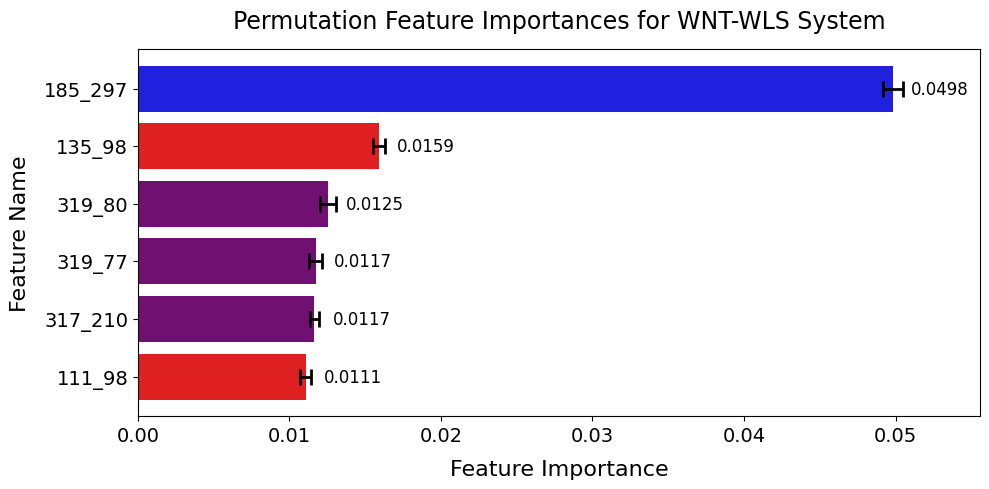

In [4]:
df_filtered = plot_feature_importances(r,X_test, 'Permutation Feature Importances for WNT-WLS System', "all_v2",0.01,True)

## save txt files for visualize contact

In [11]:
df_filtered_names =df_filtered.feature_name.astype(str)

In [12]:
label_regions = np.array([ get_region(int(idx.split('_')[0]))   for idx in df_filtered_names])


In [13]:
df_filtered_names[label_regions == 'red']

39      135_98
12      111_98
16      113_98
27      112_98
26     114_100
141    134_459
Name: feature_name, dtype: object

In [14]:
# Save each region's labels to a file
for color in ['red', 'green', 'blue', 'purple', 'gray']:
    labels_in_color = df_filtered_names[label_regions == color]
    np.savetxt(f"output/feature_importances_region_{color}.txt", labels_in_color, fmt='%s')

In [15]:
df_filtered

,feature_name,feature_importance
123,185_297,0.049836
39,135_98,0.015907
111,319_80,0.012520
95,319_77,0.011725
131,317_210,0.011653
12,111_98,0.011075
161,317_119,0.009678
58,203_175,0.009315
139,185_357,0.008709
16,113_98,0.007031


## feature importance from  the model

In [16]:
model = rf_pipeline.named_steps['rf']

/tmp/ipykernel_80386/3466091685.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_filtered, x='feature_importance', y='feature_name', palette=colors)


containers length: 35


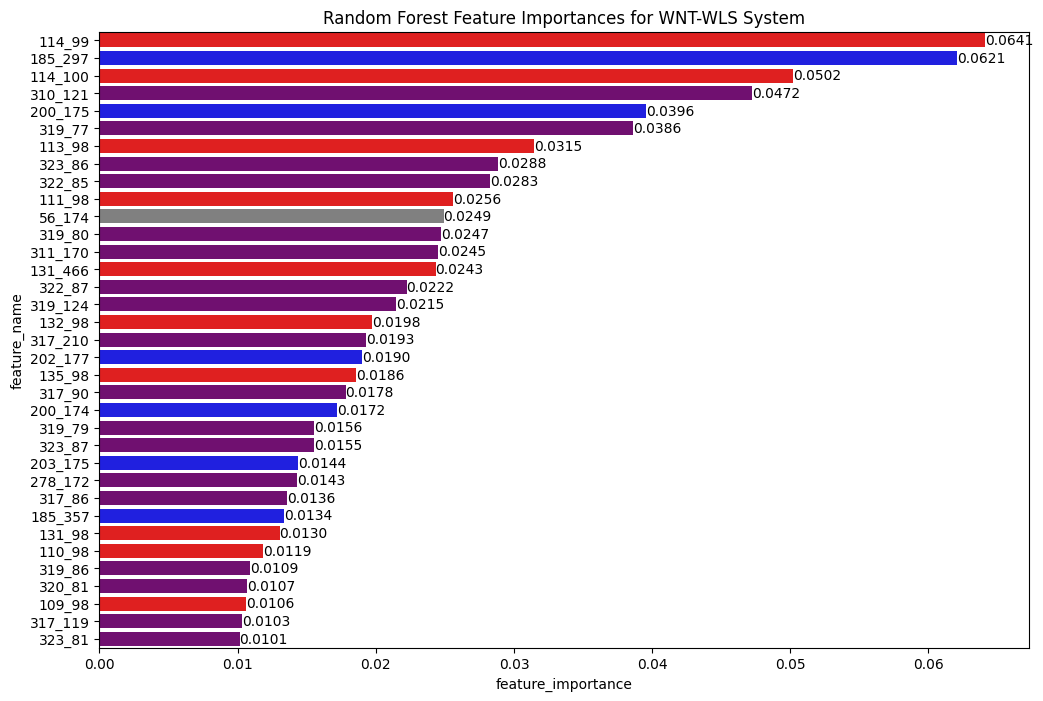

In [17]:
df_fi_rf = plot_feature_importances_rf(model, X_train,0.01, "Random Forest Feature Importances for WNT-WLS System", "all")
# Save feature importance data as CSV
df_fi_rf.to_csv("rf_model_feature_importance_0225.csv", index=False)

In [18]:
# Extra - read in the subclustering data frame

subclusters = pd.read_pickle('../07_preprocess/output/clusterbyindex_df.pkl').set_index("clusteridx")

In [19]:
subclusters[["nPoints","nSubClusters","SS"]]

,nPoints,nSubClusters,SS
clusteridx,,,
0,135,2,0.482629
1,114,43,0.317527
2,97,20,0.303685
3,87,14,0.258341
4,76,3,0.236376
5,3,1,1.000000
6,58,36,0.243869
7,79,2,0.294738
8,49,4,0.365803
